# Lab DL 9: GAN untuk Image Generation
Nama : Muhammad Fikrizza

NIM  : 2000018096

# **1. Pendahuluan**

---
## GAN Networks

In a GAN, we build two different neural networks.

Our first network is a traditional classification network, called the **DISCRIMINATOR**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set).

Our other network, called the **GENERATOR**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

<center>
<img src="https://i.ibb.co/4RyZ2Vr/gan-en.png" width=80% />
</center>
<br>

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where
* $z \sim p(z)$ are the random noise samples,
* $G(z)$ are the generated images using the neural network generator $G$, and
* $D$ is the output of the discriminator, specifying the probability of an input being real.

<br>

In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

# **2. Mounting Google Drive**

In [2]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# lokasi dataset - ubah sesuai dengan lokasi anda mengupload folder datanya
# folder ini juga digunakan untuk menyimpan model yang sudah dilatih
root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 9/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 9/


# **3. Download Dataset**
Download dataset dan simpan di gdrive yang sudah disediakan.
Kita menggunakan MNIST digit dataset

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

import os, time, glob, imageio, PIL, pathlib
from IPython.display import Image

os.chdir(root_path)
if not os.path.exists('imgs'):
    os.mkdir('imgs')

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.concatenate([X_train, X_test])

11490434/11490434 [==============================] - 0s 0us/step


Normalisasi data latih

In [4]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]

# **4. Fungsi untuk Mengolah Dataset**
Fungsi untuk mengolah dataset

In [5]:
def combine_images(images):
    num = images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=images.dtype)
    for index, img in enumerate(images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    image = image*127.5+127.5

    return image

def generate_images(generator, batch_size, sampling='normal'):

    z_size = generator.layers[0].input_shape[1]
    if sampling == 'normal':
        noise = tf.random.normal(shape=(batch_size, z_size))
    else:
        noise = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)

    generated_images = generator.predict(noise, verbose=1)

    image = combine_images(generated_images)

    filename = "generated_image.png"
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)

    return image

def generate_best_images(generator, discriminator, batch_size, sampling='normal', tries=20):

    z_size = generator.layers[0].input_shape[1]
    if sampling == 'normal':
        noise = tf.random.normal(shape=(batch_size*tries, z_size))
    else:
        noise = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)


    generated_images = generator.predict(noise, verbose=0)
    d_pret = discriminator.predict(generated_images, verbose=0)

    index = np.arange(0, batch_size*tries)
    index.resize((batch_size*tries, 1))

    pre_with_index = list(np.append(d_pret, index, axis=1))
    pre_with_index.sort(key=lambda x: x[0], reverse=True)

    nice_images = np.zeros((batch_size,) + generated_images.shape[1:3], dtype=np.float32)
    nice_images = nice_images[:, :, :, None]

    for i in range(batch_size):
        idx = int(pre_with_index[i][1])
        nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]

    image = combine_images(nice_images)

    filename = "generated_image_best.png"
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)

    return image

def show_gif(base_dir, anim_file):

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(base_dir+'/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            for i in range(3):
                writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

    print('GIF saved as', anim_file)

    with open(anim_file,'rb') as f:
        display(Image(data=f.read(), format='png'))

# **5. Membangun Model GAN**

---
# [Part 1] GAN Training
Inside the training loop, there are basically three steps to train GANs.


<center>
<img src="https://i.ibb.co/Y388bJb/gan-steps-en.png" width=80% />
</center>
<br>

First, in each iteration, we use the current Generator to generate new batch of fake data from random latent space. Then the second is we use the generated batch along with a real batch of data to train one step of the Discriminator Model (one time forward and backward pass). The objective here is to minimize the binary crossentropy loss between the fake and real class.

The last is to train the Generator Model by feeding in a batch of random latent space to generate a batch of fake data (forward pass). The batch of fake data then feed into the trained Discriminator from previous step (forward pass). The objective here is to maximize the wrongly classified data, which we can turn into minimizing correctly classified data. The loss is then used to update **ONLY** the Generator Model's weights (backward pass)


---
##1 - Define Models

As mentioned before, there are two networks inside GAN, namely Generator and Discriminator.

As a side note, The rectified linear activation unit, or ReLU for short, is a simple calculation that returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less.

It has become a best practice when developing deep convolutional neural networks generally, which it's also implemented in this exmaple.

However, best practice for GANs is to use a variation of the ReLU that allows some values less than zero and learns where the cut-off should be in each node. This is called the leaky rectified linear activation unit, or LeakyReLU for short. You can try and change the activation function yourself.


### Generator Model

The generator model must generate an output image given as input at a random point from the latent space.

The recommended approach for achieving this is to use a transpose convolutional layer with a strided convolution. This is a special type of layer that performs the convolution operation in reverse.

Intuitively, this means that setting a stride of $2×2$ will have the opposite effect, upsampling the input instead of downsampling it in the case of a normal convolutional layer.


<center>
<img src="https://i.ibb.co/s2gX3jR/generator1.png" width=70% />
</center>


By stacking a transpose convolutional layer with strided convolutions, the generator model is able to scale a given input to the desired output dimensions. It is also recommended in using Batch Normalization to standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.

## 5.1. Generator Model

In [6]:
def generator_model(latent_dim = 128):
    model = Sequential([
        Dense(1024, input_dim=latent_dim, activation='relu'),
        BatchNormalization(),
        Dense(7 * 7 * 128, activation='relu'),
        Reshape((7, 7, 128)),
        Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', activation='tanh'),
    ])
    return model

generator_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              132096    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 6272)              6428800   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

### Discriminator Model

The discriminator model is a standard convolutional neural network model that takes an image as input and must output a binary classification as to whether it is real or fake.


<center>
<img src="https://i.ibb.co/nnxBg8S/discriminator1.png" width=70% />
</center>


It is standard practice with deep convolutional networks to use pooling layers to downsample the input and feature maps with the depth of the network, like implemented below.

However, turns out this is not recommended for the DCGAN, and instead, they recommend downsampling using strided convolutions. You can try and change the `maxpool` below using strided convolution yourself.

## 5.2. Discriminator Model

In [7]:
def discriminator_model():
    model = Sequential([
        Conv2D(32, (5, 5), input_shape=(28, 28, 1), padding='same'),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (5, 5)),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(4 * 4 * 64, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 10, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

## 5.3. Gabungkan Kedua Model

In [8]:
def combine_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

# **6. Pelatihan Model GAN**

---
## 2 - Training Functions

The latent space defines the shape and distribution of the input to the generator model used to generate new images.

The DCGAN recommends sampling from a uniform distribution, meaning that the shape of the latent space is a hypercube.

The more recent best practice is to sample from a standard Gaussian distribution, meaning that the shape of the latent space is a hypersphere, with a mean of zero and a standard deviation of one.

Tom White's [Sampling Generative Networks](https://arxiv.org/abs/1609.04468), ref code https://github.com/dribnet/plat has more details

---
The discriminator model is trained using stochastic gradient descent with mini-batches.

The best practice is to update the discriminator with separate batches of real and fake images rather than combining real and fake images into a single batch.

This can be achieved by updating the model weights for the discriminator model with two separate calls to the `train_on_batch()` function. You can try and change this yourself.

---
It is common to use the class label 1 to represent real images and class label 0 to represent fake images when training the discriminator model.

These are called hard labels, as the label values are precise or crisp.

It is a good practice to use soft labels as mentioned by Salimans et. al. 2016. Such values are slightly more or less than 1.0 or slightly more than 0.0 for real and fake images respectively, where the variation for each image is random.

This is often referred to as label noise or smoothing and can have a regularizing effect when training the model.

## 6.1. Fungsi Pelatihan

In [9]:
def train_gan(X_train, Y_train,
              batch_size, epochs,
              models, sampling='normal',
              save_every=500, print_every=100):

    def sampling_fn(shape):
        if sampling == 'normal':
            return tf.random.normal(shape)
        else:
            return tf.random.uniform(shape, minval=-1, maxval=1)


    g, d, d_on_g = models


    print('Start training using random', sampling, 'distribution')
    print('Number of batches', int(X_train.shape[0]/batch_size))

    z_size = g.layers[0].input_shape[1]
    seed_saved = sampling_fn(shape=(16, z_size))
    img_count = 0

    start = time.time()

    for epoch in range(epochs):
        print("\n-------------------------------\nEpoch is", epoch)

        for index in range(int(X_train.shape[0]/batch_size)):

            noise = sampling_fn(shape=(batch_size, z_size))

            generated_images = g.predict(noise, verbose=0)

            image_batch = X_train[index*batch_size:(index+1)*batch_size]

            if index % save_every == 0:
                for_save = g.predict(seed_saved)
                image = combine_images(for_save)

                # simpan di folder gdrive imgs
                plt.imshow(image, cmap=plt.get_cmap('gray'))
                filename = 'imgs/image_'+'{:03}'.format(img_count)+'.png'
                plt.axis('off')
                plt.savefig(filename)
                plt.show()
                img_count += 1

            X = np.concatenate((image_batch, generated_images))
            y = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            y += 0.05 * tf.random.uniform(tf.shape(y))

            d_loss = d.train_on_batch(X, y)

            noise = sampling_fn(shape=(batch_size, z_size))

            d.trainable = False
            y = tf.ones((batch_size, 1))
            g_loss = d_on_g.train_on_batch(noise, y)

            if index % print_every == 0:
                print("batch %d, g_loss : %f, d_loss : %f" % (index, g_loss, d_loss))

            d.trainable = True

    end = time.time()

    print('Training ended in', (end-start)/60, 'minutes')
    models = [g, d, d_on_g]

    return models

In [10]:
g_model = generator_model()
d_model = discriminator_model()

In [11]:
d_optim = Adam(learning_rate=0.0003, beta_1=0.5)
g_optim = Adam(learning_rate=0.0003, beta_1=0.5)

d_model.trainable = False
d_on_g = combine_model(g_model, d_model)
d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)

d_model.trainable = True
d_model.compile(loss='binary_crossentropy', optimizer=d_optim)

models = [g_model, d_model, d_on_g]

## 6.2. Pelatihan GAN

Start training using random normal distribution
Number of batches 311

-------------------------------
Epoch is 0
1/1 [==============================] - 0s 69ms/step


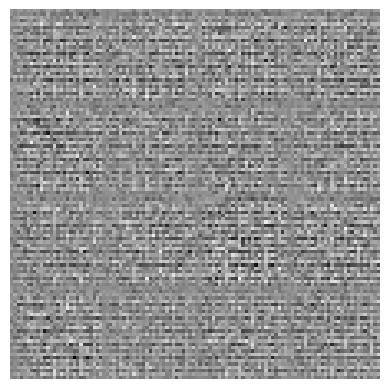

batch 0, g_loss : 0.148524, d_loss : 0.668091
batch 100, g_loss : 0.000000, d_loss : -0.843710
batch 200, g_loss : 11.382498, d_loss : -0.395240
batch 300, g_loss : 0.297475, d_loss : 0.196875

-------------------------------
Epoch is 1
1/1 [==============================] - 0s 18ms/step


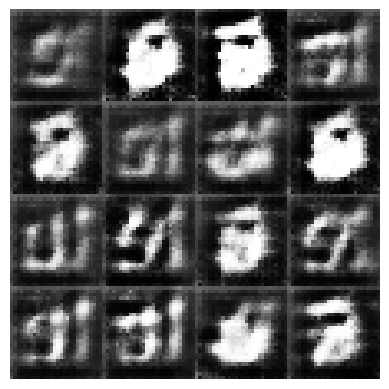

batch 0, g_loss : 2.416762, d_loss : 0.211488
batch 100, g_loss : 0.393503, d_loss : 0.503475
batch 200, g_loss : 1.579113, d_loss : 0.275749
batch 300, g_loss : 1.455562, d_loss : 0.332770

-------------------------------
Epoch is 2
1/1 [==============================] - 0s 19ms/step


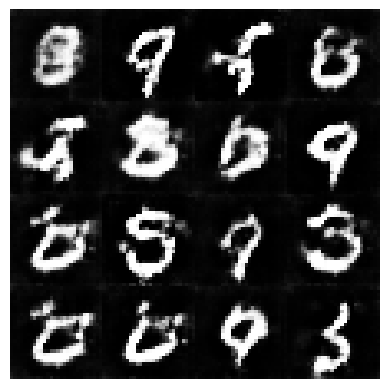

batch 0, g_loss : 1.448498, d_loss : 0.350147
batch 100, g_loss : 1.580455, d_loss : 0.653617
batch 200, g_loss : 1.154629, d_loss : 0.461051
batch 300, g_loss : 1.534670, d_loss : 0.409649

-------------------------------
Epoch is 3
1/1 [==============================] - 0s 18ms/step


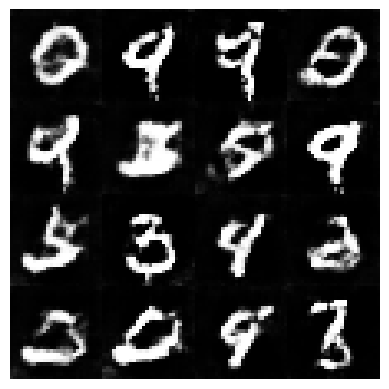

batch 0, g_loss : 1.011172, d_loss : 0.487852
batch 100, g_loss : 1.541280, d_loss : 0.756013
batch 200, g_loss : 0.682792, d_loss : 0.559877
batch 300, g_loss : 1.481303, d_loss : 0.443010

-------------------------------
Epoch is 4
1/1 [==============================] - 0s 23ms/step


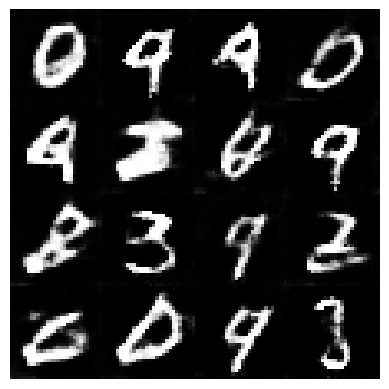

batch 0, g_loss : 0.961175, d_loss : 0.632522
batch 100, g_loss : 2.036180, d_loss : 0.845106
batch 200, g_loss : 1.328286, d_loss : 0.526848
batch 300, g_loss : 1.644453, d_loss : 0.629473

-------------------------------
Epoch is 5
1/1 [==============================] - 0s 19ms/step


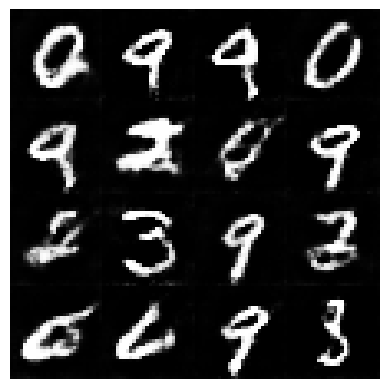

batch 0, g_loss : 0.951702, d_loss : 0.681813
batch 100, g_loss : 2.002062, d_loss : 0.693773
batch 200, g_loss : 1.417606, d_loss : 0.555916
batch 300, g_loss : 1.238746, d_loss : 0.493055

-------------------------------
Epoch is 6
1/1 [==============================] - 0s 28ms/step


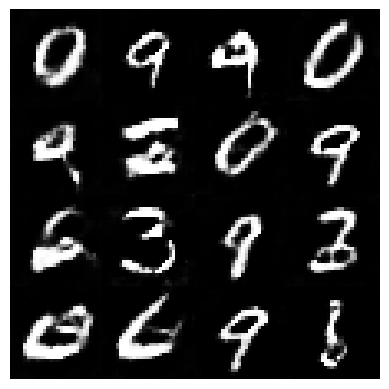

batch 0, g_loss : 0.680813, d_loss : 0.787642
batch 100, g_loss : 1.670317, d_loss : 0.649889
batch 200, g_loss : 1.020912, d_loss : 0.557700
batch 300, g_loss : 1.307792, d_loss : 0.489749

-------------------------------
Epoch is 7
1/1 [==============================] - 0s 22ms/step


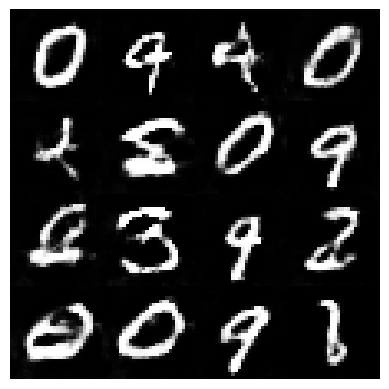

batch 0, g_loss : 0.748352, d_loss : 0.705040
batch 100, g_loss : 1.667961, d_loss : 0.672210
batch 200, g_loss : 0.782305, d_loss : 0.564032
batch 300, g_loss : 1.209926, d_loss : 0.526005

-------------------------------
Epoch is 8
1/1 [==============================] - 0s 19ms/step


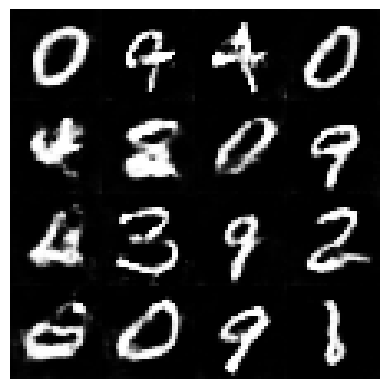

batch 0, g_loss : 0.778824, d_loss : 0.717490
batch 100, g_loss : 1.414189, d_loss : 0.604944
batch 200, g_loss : 0.935971, d_loss : 0.545390
batch 300, g_loss : 0.949040, d_loss : 0.558075

-------------------------------
Epoch is 9
1/1 [==============================] - 0s 17ms/step


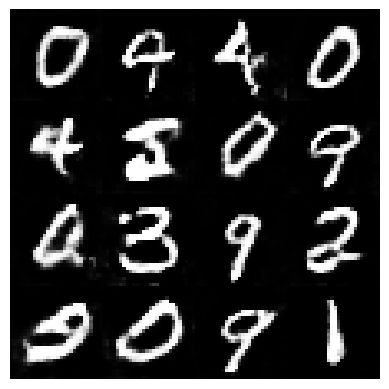

batch 0, g_loss : 0.733969, d_loss : 0.706299
batch 100, g_loss : 1.385573, d_loss : 0.677052
batch 200, g_loss : 0.983858, d_loss : 0.569449
batch 300, g_loss : 1.044394, d_loss : 0.507057

-------------------------------
Epoch is 10
1/1 [==============================] - 0s 23ms/step


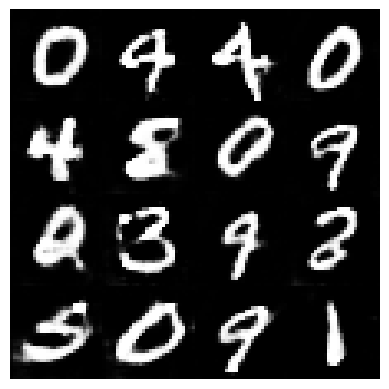

batch 0, g_loss : 0.686895, d_loss : 0.612515
batch 100, g_loss : 1.286195, d_loss : 0.709701
batch 200, g_loss : 0.976089, d_loss : 0.571243
batch 300, g_loss : 1.213237, d_loss : 0.542833

-------------------------------
Epoch is 11
1/1 [==============================] - 0s 38ms/step


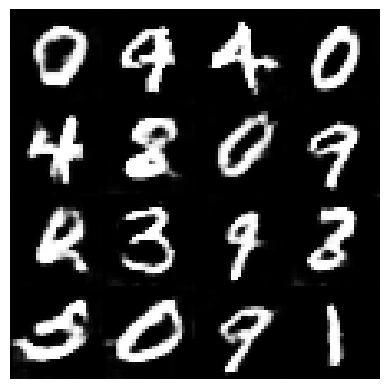

batch 0, g_loss : 0.801074, d_loss : 0.599214
batch 100, g_loss : 1.286959, d_loss : 0.649564
batch 200, g_loss : 0.769376, d_loss : 0.568250
batch 300, g_loss : 1.144931, d_loss : 0.553139

-------------------------------
Epoch is 12
1/1 [==============================] - 0s 20ms/step


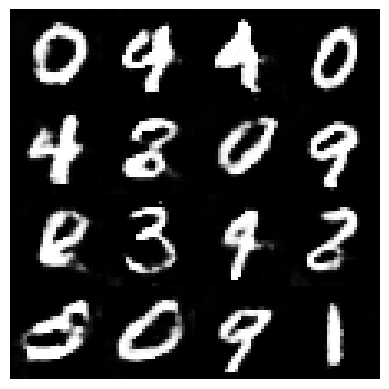

batch 0, g_loss : 0.903761, d_loss : 0.636831
batch 100, g_loss : 1.480824, d_loss : 0.704313
batch 200, g_loss : 0.766404, d_loss : 0.594479
batch 300, g_loss : 1.074013, d_loss : 0.499986

-------------------------------
Epoch is 13
1/1 [==============================] - 0s 18ms/step


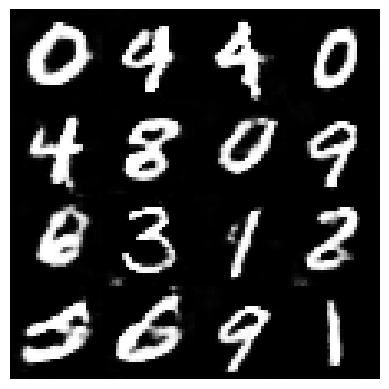

batch 0, g_loss : 0.865318, d_loss : 0.616894
batch 100, g_loss : 1.589382, d_loss : 0.695291
batch 200, g_loss : 0.631702, d_loss : 0.635470
batch 300, g_loss : 1.056618, d_loss : 0.514259

-------------------------------
Epoch is 14
1/1 [==============================] - 0s 20ms/step


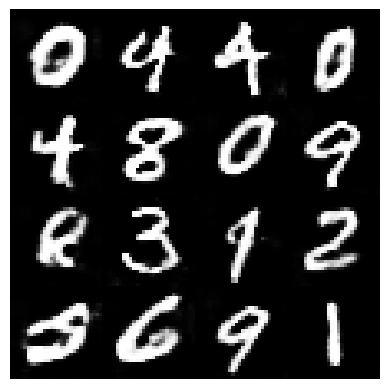

batch 0, g_loss : 0.658690, d_loss : 0.649843
batch 100, g_loss : 1.056839, d_loss : 0.629328
batch 200, g_loss : 0.729833, d_loss : 0.592323
batch 300, g_loss : 1.062579, d_loss : 0.536869

-------------------------------
Epoch is 15
1/1 [==============================] - 0s 19ms/step


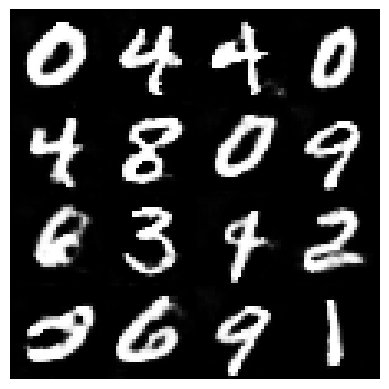

batch 0, g_loss : 0.757192, d_loss : 0.622139
batch 100, g_loss : 1.259476, d_loss : 0.643745
batch 200, g_loss : 0.965161, d_loss : 0.638602
batch 300, g_loss : 1.248691, d_loss : 0.524758

-------------------------------
Epoch is 16
1/1 [==============================] - 0s 27ms/step


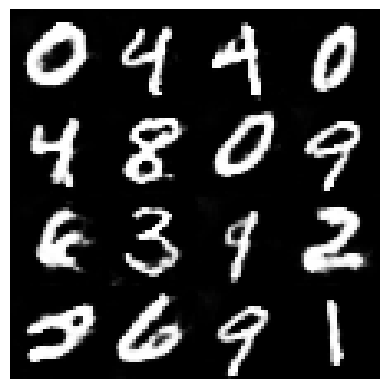

batch 0, g_loss : 0.795480, d_loss : 0.597269
batch 100, g_loss : 0.726495, d_loss : 0.634005
batch 200, g_loss : 1.019221, d_loss : 0.608444
batch 300, g_loss : 0.910776, d_loss : 0.530808

-------------------------------
Epoch is 17
1/1 [==============================] - 0s 18ms/step


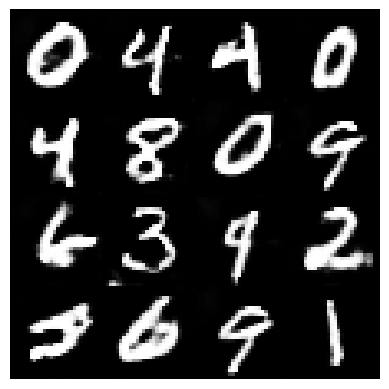

batch 0, g_loss : 0.721560, d_loss : 0.608496
batch 100, g_loss : 1.205275, d_loss : 0.654496
batch 200, g_loss : 0.877685, d_loss : 0.572234
batch 300, g_loss : 1.146793, d_loss : 0.509714

-------------------------------
Epoch is 18
1/1 [==============================] - 0s 19ms/step


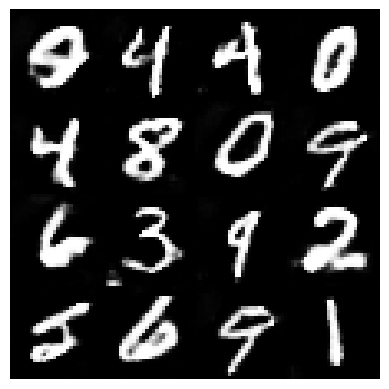

batch 0, g_loss : 0.744223, d_loss : 0.612844
batch 100, g_loss : 1.031397, d_loss : 0.628938
batch 200, g_loss : 1.045320, d_loss : 0.590276
batch 300, g_loss : 0.841378, d_loss : 0.541897

-------------------------------
Epoch is 19
1/1 [==============================] - 0s 17ms/step


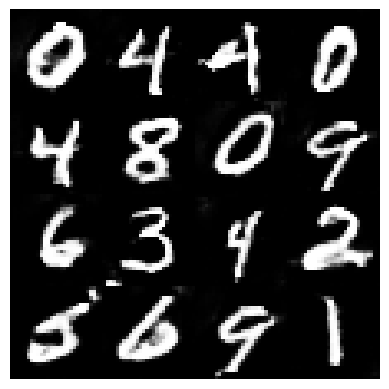

batch 0, g_loss : 0.608582, d_loss : 0.703987
batch 100, g_loss : 1.579275, d_loss : 0.699676
batch 200, g_loss : 1.178656, d_loss : 0.597222
batch 300, g_loss : 0.927426, d_loss : 0.505303

-------------------------------
Epoch is 20
1/1 [==============================] - 0s 18ms/step


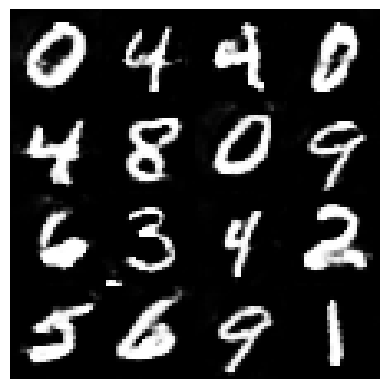

batch 0, g_loss : 0.794469, d_loss : 0.626346
batch 100, g_loss : 0.971533, d_loss : 0.652503
batch 200, g_loss : 1.316820, d_loss : 0.603985
batch 300, g_loss : 0.820261, d_loss : 0.496162

-------------------------------
Epoch is 21
1/1 [==============================] - 0s 22ms/step


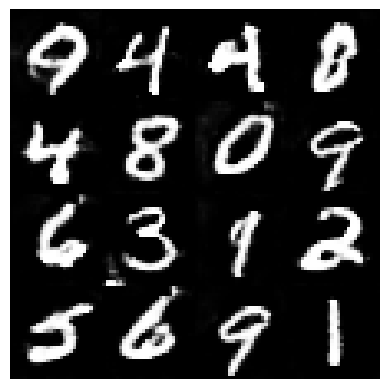

batch 0, g_loss : 0.701731, d_loss : 0.612619
batch 100, g_loss : 0.966188, d_loss : 0.665189
batch 200, g_loss : 1.306772, d_loss : 0.586521
batch 300, g_loss : 0.934279, d_loss : 0.517342

-------------------------------
Epoch is 22
1/1 [==============================] - 0s 26ms/step


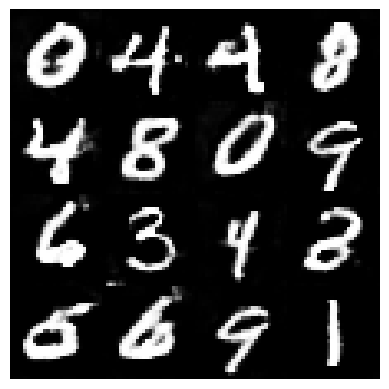

batch 0, g_loss : 0.631333, d_loss : 0.638635
batch 100, g_loss : 0.856372, d_loss : 0.641418
batch 200, g_loss : 0.721839, d_loss : 0.580313
batch 300, g_loss : 0.971732, d_loss : 0.512025

-------------------------------
Epoch is 23
1/1 [==============================] - 0s 19ms/step


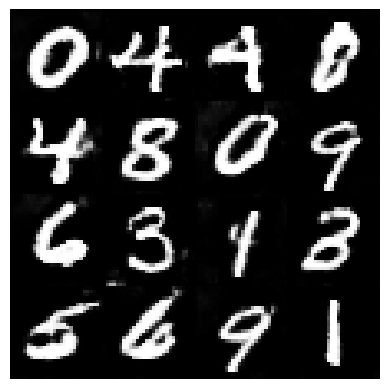

batch 0, g_loss : 0.704134, d_loss : 0.605628
batch 100, g_loss : 0.991576, d_loss : 0.645687
batch 200, g_loss : 0.909860, d_loss : 0.538533
batch 300, g_loss : 0.962882, d_loss : 0.512964

-------------------------------
Epoch is 24
1/1 [==============================] - 0s 18ms/step


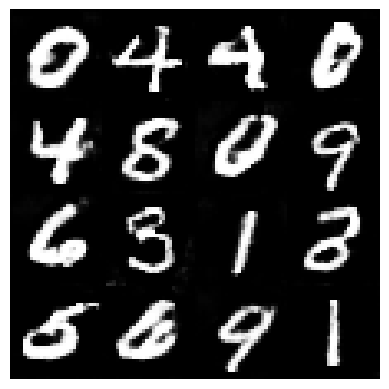

batch 0, g_loss : 0.807563, d_loss : 0.593383
batch 100, g_loss : 0.875256, d_loss : 0.607086
batch 200, g_loss : 0.867649, d_loss : 0.568202
batch 300, g_loss : 0.942006, d_loss : 0.477054

-------------------------------
Epoch is 25
1/1 [==============================] - 0s 18ms/step


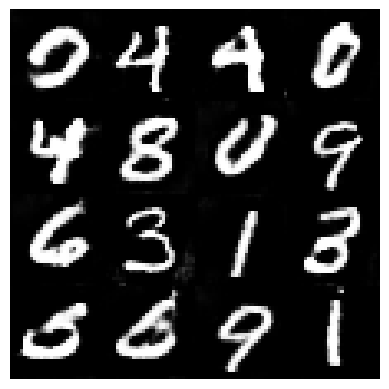

batch 0, g_loss : 0.728657, d_loss : 0.696403
batch 100, g_loss : 0.913974, d_loss : 0.610136
batch 200, g_loss : 1.076963, d_loss : 0.575388
batch 300, g_loss : 0.935474, d_loss : 0.488015

-------------------------------
Epoch is 26
1/1 [==============================] - 0s 22ms/step


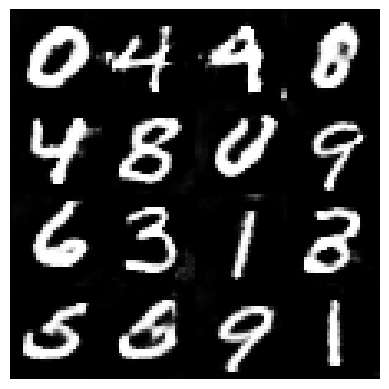

batch 0, g_loss : 0.774862, d_loss : 0.626627
batch 100, g_loss : 1.190943, d_loss : 0.708469
batch 200, g_loss : 1.098393, d_loss : 0.546328
batch 300, g_loss : 1.072999, d_loss : 0.469368

-------------------------------
Epoch is 27
1/1 [==============================] - 0s 65ms/step


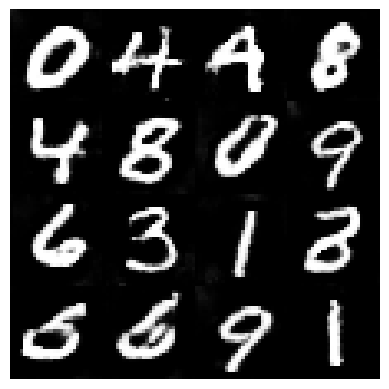

batch 0, g_loss : 0.818345, d_loss : 0.607737
batch 100, g_loss : 1.175028, d_loss : 0.678538
batch 200, g_loss : 1.099598, d_loss : 0.550839
batch 300, g_loss : 1.307272, d_loss : 0.488882

-------------------------------
Epoch is 28
1/1 [==============================] - 0s 29ms/step


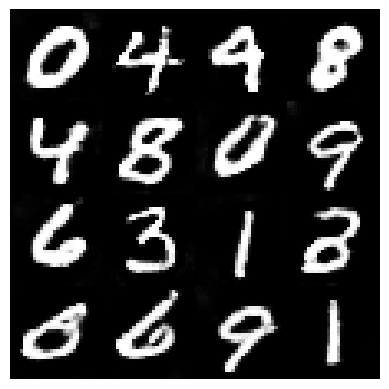

batch 0, g_loss : 0.781255, d_loss : 0.622524
batch 100, g_loss : 1.393651, d_loss : 0.728566
batch 200, g_loss : 1.508904, d_loss : 0.583565
batch 300, g_loss : 0.739505, d_loss : 0.505035

-------------------------------
Epoch is 29
1/1 [==============================] - 0s 39ms/step


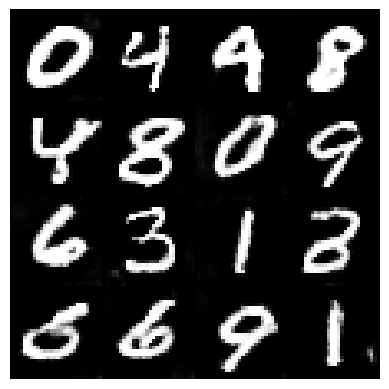

batch 0, g_loss : 0.855841, d_loss : 0.628756
batch 100, g_loss : 1.228379, d_loss : 0.575106
batch 200, g_loss : 1.025212, d_loss : 0.546416
batch 300, g_loss : 1.585375, d_loss : 0.470347

-------------------------------
Epoch is 30
1/1 [==============================] - 0s 18ms/step


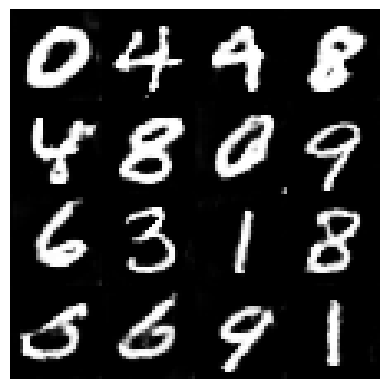

batch 0, g_loss : 0.838459, d_loss : 0.590891
batch 100, g_loss : 1.789592, d_loss : 0.636660
batch 200, g_loss : 0.752911, d_loss : 0.531373
batch 300, g_loss : 1.158251, d_loss : 0.493426

-------------------------------
Epoch is 31
1/1 [==============================] - 0s 18ms/step


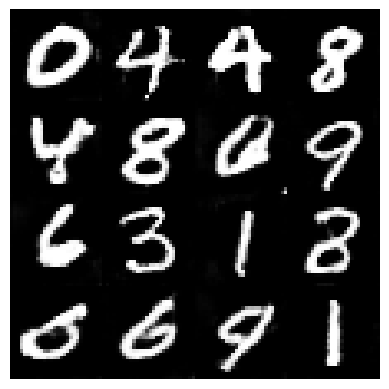

batch 0, g_loss : 0.897619, d_loss : 0.588371
batch 100, g_loss : 1.626324, d_loss : 0.685790
batch 200, g_loss : 1.161749, d_loss : 0.573666
batch 300, g_loss : 1.238516, d_loss : 0.477443

-------------------------------
Epoch is 32
1/1 [==============================] - 0s 21ms/step


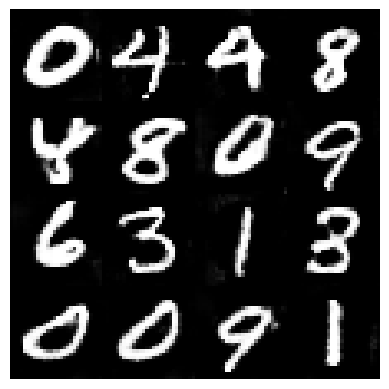

batch 0, g_loss : 0.674240, d_loss : 0.610528
batch 100, g_loss : 0.936547, d_loss : 0.613185
batch 200, g_loss : 0.941561, d_loss : 0.561110
batch 300, g_loss : 1.196338, d_loss : 0.461801

-------------------------------
Epoch is 33
1/1 [==============================] - 0s 25ms/step


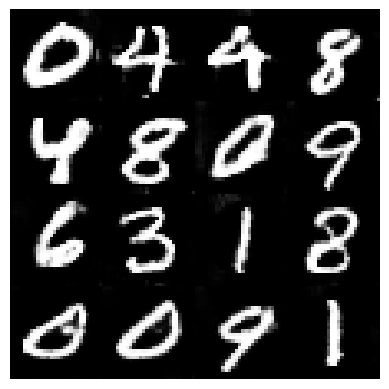

batch 0, g_loss : 0.695076, d_loss : 0.740390
batch 100, g_loss : 1.843746, d_loss : 0.889092
batch 200, g_loss : 1.034022, d_loss : 0.538052
batch 300, g_loss : 1.300392, d_loss : 0.451104

-------------------------------
Epoch is 34
1/1 [==============================] - 0s 19ms/step


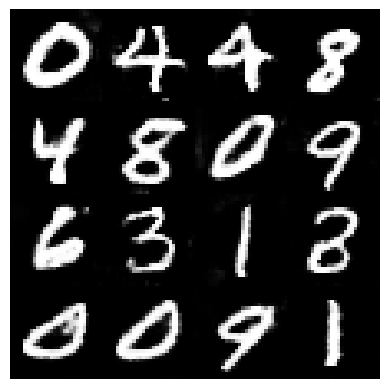

batch 0, g_loss : 0.865584, d_loss : 0.588444
batch 100, g_loss : 1.464028, d_loss : 0.701658
batch 200, g_loss : 1.274615, d_loss : 0.568710
batch 300, g_loss : 1.265064, d_loss : 0.474432

-------------------------------
Epoch is 35
1/1 [==============================] - 0s 17ms/step


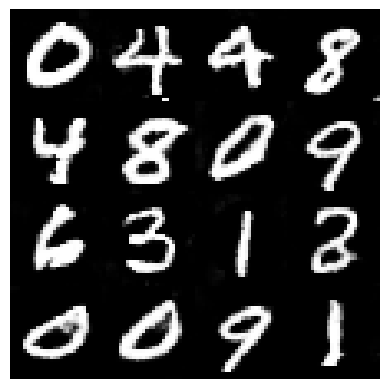

batch 0, g_loss : 0.802942, d_loss : 0.548889
batch 100, g_loss : 1.003239, d_loss : 0.578100
batch 200, g_loss : 1.415334, d_loss : 0.602536
batch 300, g_loss : 1.142398, d_loss : 0.452568

-------------------------------
Epoch is 36
1/1 [==============================] - 0s 42ms/step


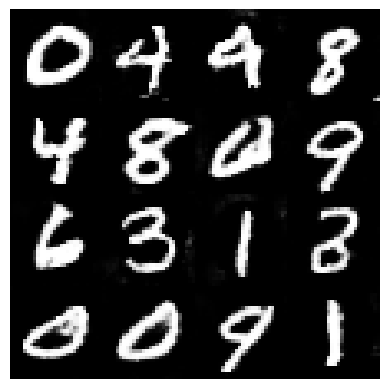

batch 0, g_loss : 0.737323, d_loss : 0.630493
batch 100, g_loss : 2.081394, d_loss : 0.731967
batch 200, g_loss : 0.843642, d_loss : 0.538511
batch 300, g_loss : 0.741087, d_loss : 0.517509

-------------------------------
Epoch is 37
1/1 [==============================] - 0s 20ms/step


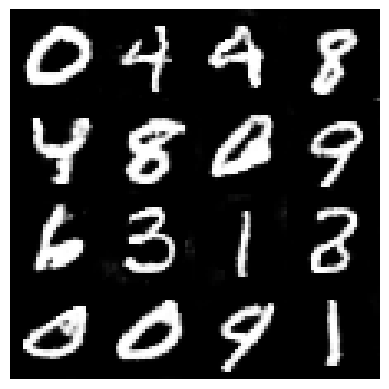

batch 0, g_loss : 0.831238, d_loss : 0.581907
batch 100, g_loss : 1.072672, d_loss : 0.619985
batch 200, g_loss : 1.282537, d_loss : 0.539912
batch 300, g_loss : 1.055669, d_loss : 0.423928

-------------------------------
Epoch is 38
1/1 [==============================] - 0s 18ms/step


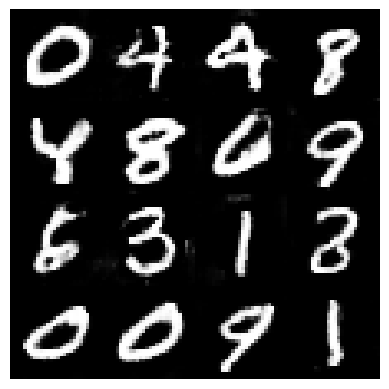

batch 0, g_loss : 0.915391, d_loss : 0.564516
batch 100, g_loss : 1.086526, d_loss : 0.584640
batch 200, g_loss : 1.056135, d_loss : 0.511624
batch 300, g_loss : 0.978936, d_loss : 0.431516

-------------------------------
Epoch is 39
1/1 [==============================] - 0s 21ms/step


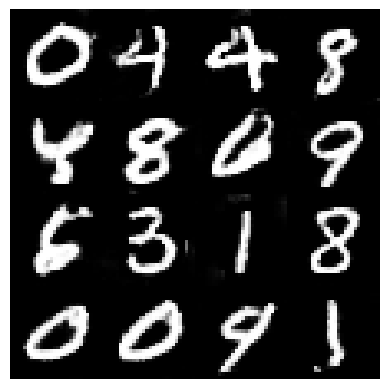

batch 0, g_loss : 0.705286, d_loss : 0.569371
batch 100, g_loss : 1.334731, d_loss : 0.606727
batch 200, g_loss : 1.070780, d_loss : 0.506150
batch 300, g_loss : 1.373402, d_loss : 0.446681

-------------------------------
Epoch is 40
1/1 [==============================] - 0s 20ms/step


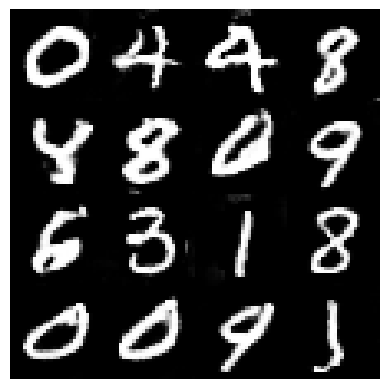

batch 0, g_loss : 0.805001, d_loss : 0.565173
batch 100, g_loss : 1.385257, d_loss : 0.640665
batch 200, g_loss : 0.838607, d_loss : 0.555333
batch 300, g_loss : 1.363353, d_loss : 0.422331

-------------------------------
Epoch is 41
1/1 [==============================] - 0s 19ms/step


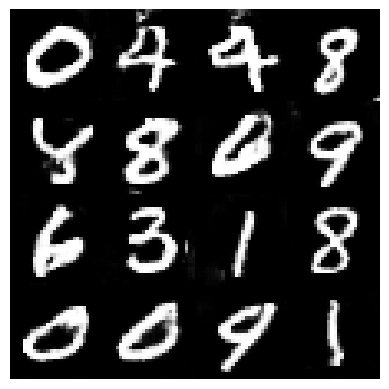

batch 0, g_loss : 0.839937, d_loss : 0.590462
batch 100, g_loss : 0.869308, d_loss : 0.525162
batch 200, g_loss : 1.892810, d_loss : 0.658477
batch 300, g_loss : 1.007419, d_loss : 0.410112

-------------------------------
Epoch is 42
1/1 [==============================] - 0s 19ms/step


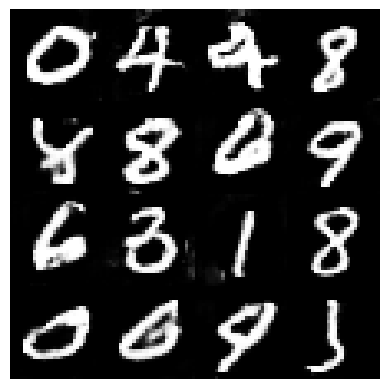

batch 0, g_loss : 0.799630, d_loss : 0.586732
batch 100, g_loss : 1.072331, d_loss : 0.568517
batch 200, g_loss : 1.123056, d_loss : 0.530821
batch 300, g_loss : 1.273646, d_loss : 0.427824

-------------------------------
Epoch is 43
1/1 [==============================] - 0s 21ms/step


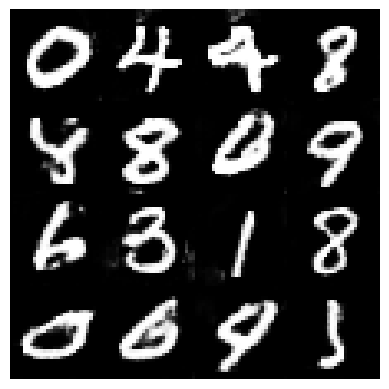

batch 0, g_loss : 0.918745, d_loss : 0.568405
batch 100, g_loss : 1.115047, d_loss : 0.574019
batch 200, g_loss : 1.484496, d_loss : 0.565680
batch 300, g_loss : 1.420002, d_loss : 0.446677

-------------------------------
Epoch is 44
1/1 [==============================] - 0s 21ms/step


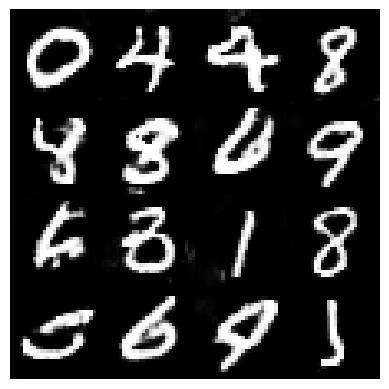

batch 0, g_loss : 0.744029, d_loss : 0.533246
batch 100, g_loss : 1.388396, d_loss : 0.609265
batch 200, g_loss : 1.183842, d_loss : 0.492424
batch 300, g_loss : 1.211135, d_loss : 0.441198

-------------------------------
Epoch is 45
1/1 [==============================] - 0s 18ms/step


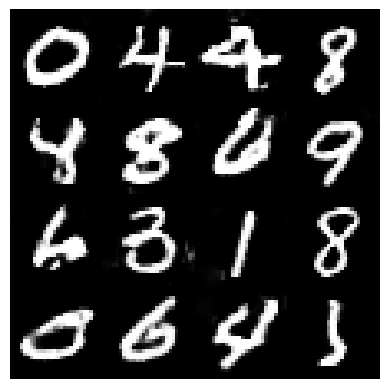

batch 0, g_loss : 0.897126, d_loss : 0.514262
batch 100, g_loss : 1.196860, d_loss : 0.588076
batch 200, g_loss : 1.204672, d_loss : 0.530062
batch 300, g_loss : 1.188582, d_loss : 0.421051

-------------------------------
Epoch is 46
1/1 [==============================] - 0s 28ms/step


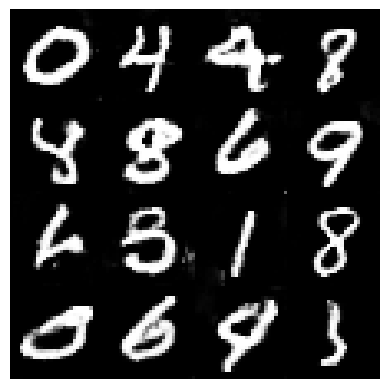

batch 0, g_loss : 0.751317, d_loss : 0.668849
batch 100, g_loss : 0.805064, d_loss : 0.509752
batch 200, g_loss : 1.289467, d_loss : 0.499390
batch 300, g_loss : 1.130642, d_loss : 0.451155

-------------------------------
Epoch is 47
1/1 [==============================] - 0s 18ms/step


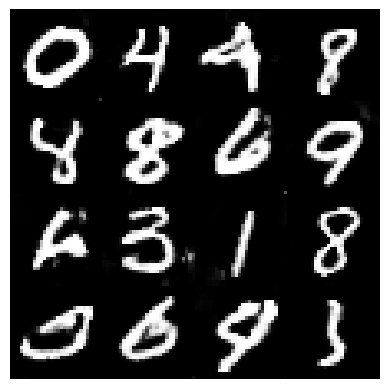

batch 0, g_loss : 0.711576, d_loss : 0.593171
batch 100, g_loss : 1.571940, d_loss : 0.640490
batch 200, g_loss : 1.393667, d_loss : 0.508799
batch 300, g_loss : 1.145811, d_loss : 0.441190

-------------------------------
Epoch is 48
1/1 [==============================] - 0s 20ms/step


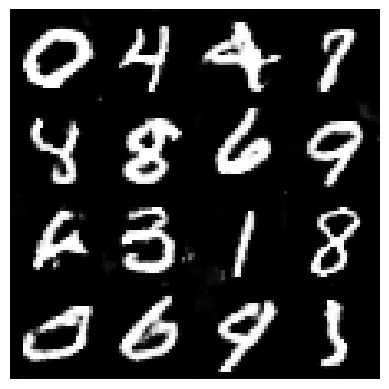

batch 0, g_loss : 0.768565, d_loss : 0.600036
batch 100, g_loss : 1.335722, d_loss : 0.622142
batch 200, g_loss : 1.640262, d_loss : 0.531262
batch 300, g_loss : 1.158560, d_loss : 0.434911

-------------------------------
Epoch is 49
1/1 [==============================] - 0s 18ms/step


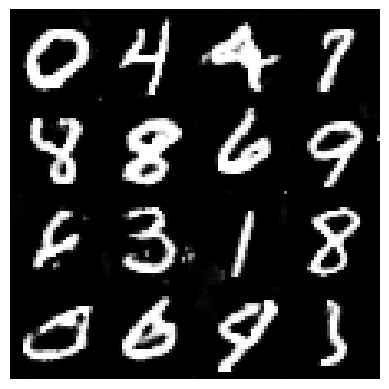

batch 0, g_loss : 0.861429, d_loss : 0.554333
batch 100, g_loss : 1.386048, d_loss : 0.607752
batch 200, g_loss : 0.831019, d_loss : 0.513610
batch 300, g_loss : 1.111338, d_loss : 0.434090
Training ended in 35.39741129080455 minutes


In [12]:
batch = 225
epochs = 50
g_model, d_model, _ = train_gan(X_train, y_train, batch, epochs, models)

In [13]:
show_gif('imgs', 'GAN.gif')

Output hidden; open in https://colab.research.google.com to view.

# **7. Evaluasi Model**

1/1 [==============================] - 0s 69ms/step


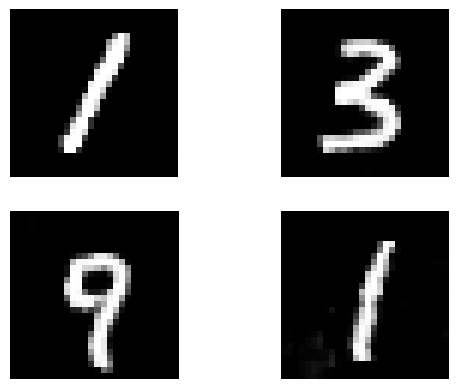

In [14]:
seed = tf.random.normal(shape=(4, 128))
images = g_model.predict(seed)

for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 74ms/step


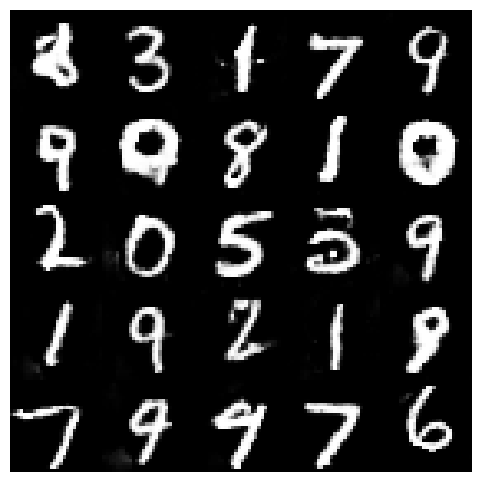

In [15]:
images = generate_images(g_model, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

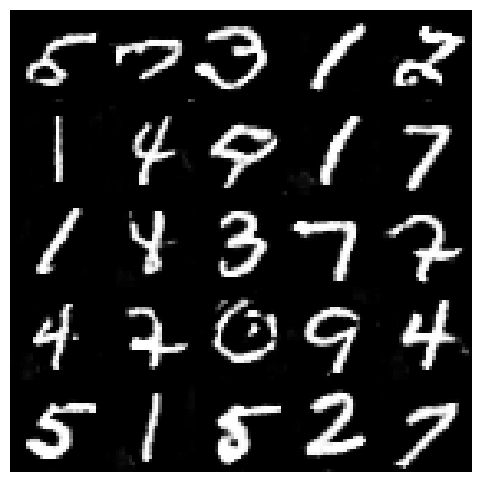

In [16]:
images = generate_best_images(g_model, d_model, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

#**8. POSTEST**

1.   Ubah dataset pelatihan di tahap 3. Download Dataset
menjadi dataset fashion MNIST.
2.   download fashion mnist dataset
(X_train, y_train), (X_test, y_test) =
tf.keras.datasets.fashion_mnist.load_data()
2.   Lalu latih model GAN dengan dataset tersebut sehingga
bisa membuat citra dari data fashion MNIST.
2.   Analisis hasilnya apakah mirip dengan citra di dataset?




##Import Dataset

In [17]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = np.concatenate([X_train, X_test])

4422102/4422102 [==============================] - 0s 0us/step


Normalisasi Dataset

In [18]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]

##Training Model

Membuat Model Generator dan Discriminator baru

In [20]:
g_model_post = generator_model()
d_model_post = discriminator_model()

Melakukan Training Model Dengan Data Fashion MNIST

Start training using random normal distribution
Number of batches 311

-------------------------------
Epoch is 0
1/1 [==============================] - 0s 32ms/step


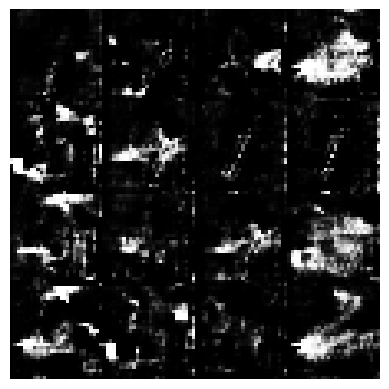

batch 0, g_loss : 0.717738, d_loss : -0.091454
batch 100, g_loss : 0.039910, d_loss : -0.467141
batch 200, g_loss : 0.000000, d_loss : 0.111671
batch 300, g_loss : 2.564778, d_loss : 0.160413

-------------------------------
Epoch is 1
1/1 [==============================] - 0s 19ms/step


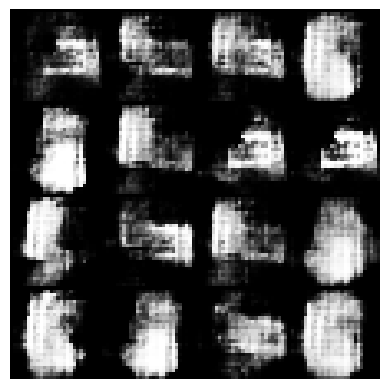

batch 0, g_loss : 0.414530, d_loss : 0.152123
batch 100, g_loss : 4.600543, d_loss : -0.341781
batch 200, g_loss : 1.622263, d_loss : 0.189994
batch 300, g_loss : 0.555322, d_loss : 0.229060

-------------------------------
Epoch is 2
1/1 [==============================] - 0s 28ms/step


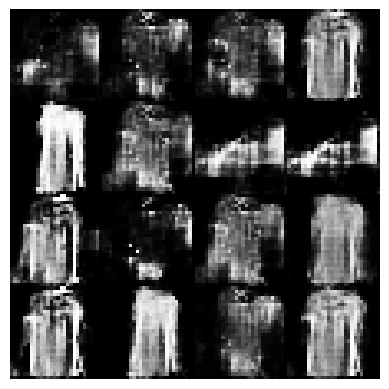

batch 0, g_loss : 1.158672, d_loss : 0.085837
batch 100, g_loss : 0.970080, d_loss : 0.213333
batch 200, g_loss : 0.430254, d_loss : -0.130085
batch 300, g_loss : 0.427864, d_loss : -0.132301

-------------------------------
Epoch is 3
1/1 [==============================] - 0s 27ms/step


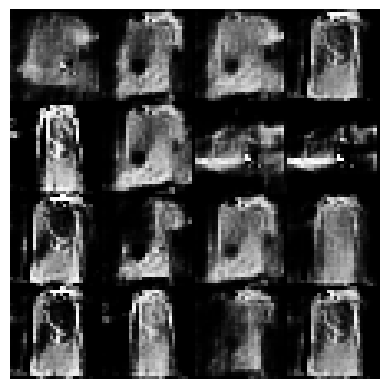

batch 0, g_loss : 1.447656, d_loss : -0.330246
batch 100, g_loss : 0.479918, d_loss : -0.451775
batch 200, g_loss : 0.016836, d_loss : -0.910767
batch 300, g_loss : 0.003425, d_loss : -1.332482

-------------------------------
Epoch is 4
1/1 [==============================] - 0s 21ms/step


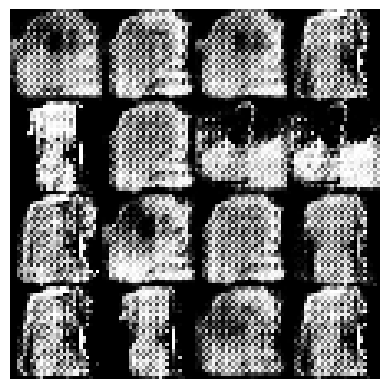

batch 0, g_loss : 0.006484, d_loss : -1.404416
batch 100, g_loss : 3.359511, d_loss : -0.956696
batch 200, g_loss : 0.009069, d_loss : -1.044422
batch 300, g_loss : 3.151995, d_loss : -1.218001

-------------------------------
Epoch is 5
1/1 [==============================] - 0s 19ms/step


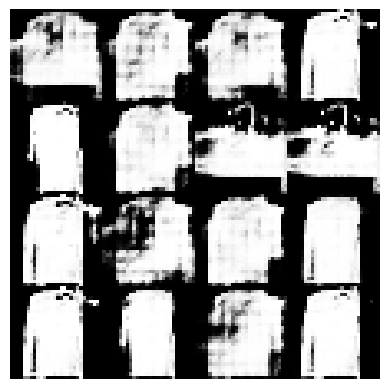

batch 0, g_loss : 4.430078, d_loss : -1.289058
batch 100, g_loss : 0.022458, d_loss : -0.874614
batch 200, g_loss : 1.962694, d_loss : -0.421266
batch 300, g_loss : 1.402962, d_loss : -1.106648

-------------------------------
Epoch is 6
1/1 [==============================] - 0s 28ms/step


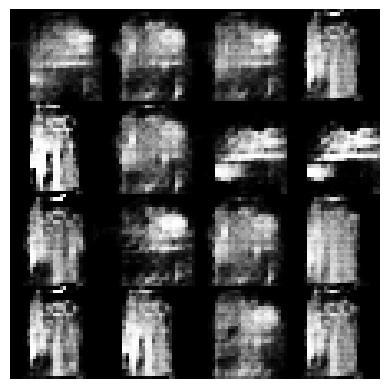

batch 0, g_loss : 0.025815, d_loss : -0.802784
batch 100, g_loss : 3.294239, d_loss : -1.582440
batch 200, g_loss : 1.494680, d_loss : -0.990904
batch 300, g_loss : 3.864429, d_loss : -1.080965

-------------------------------
Epoch is 7
1/1 [==============================] - 0s 19ms/step


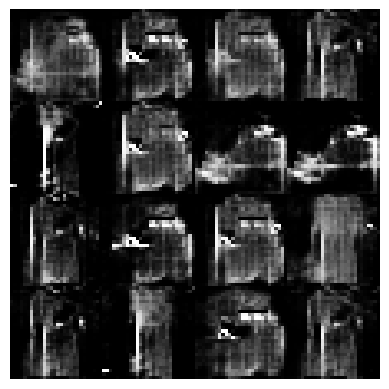

batch 0, g_loss : 2.375783, d_loss : -1.313365
batch 100, g_loss : 0.006776, d_loss : -1.200390
batch 200, g_loss : 2.000170, d_loss : -0.439718
batch 300, g_loss : 0.100801, d_loss : -0.658265

-------------------------------
Epoch is 8
1/1 [==============================] - 0s 20ms/step


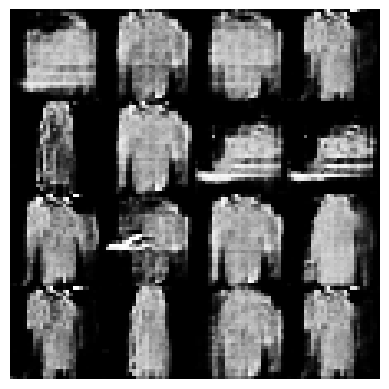

batch 0, g_loss : 0.110104, d_loss : -0.395273
batch 100, g_loss : 2.329525, d_loss : -1.434808
batch 200, g_loss : 2.350847, d_loss : -1.318514
batch 300, g_loss : 0.307711, d_loss : -0.839060

-------------------------------
Epoch is 9
1/1 [==============================] - 0s 20ms/step


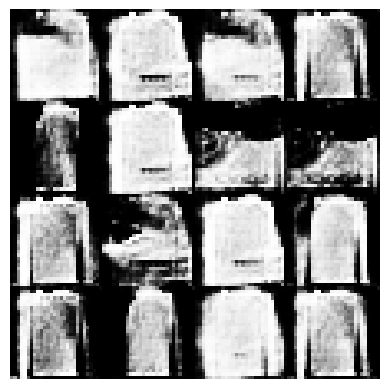

batch 0, g_loss : 0.037918, d_loss : -0.939710
batch 100, g_loss : 0.549916, d_loss : -0.692974
batch 200, g_loss : 1.484025, d_loss : -1.769927
batch 300, g_loss : 0.168944, d_loss : -1.455479

-------------------------------
Epoch is 10
1/1 [==============================] - 0s 18ms/step


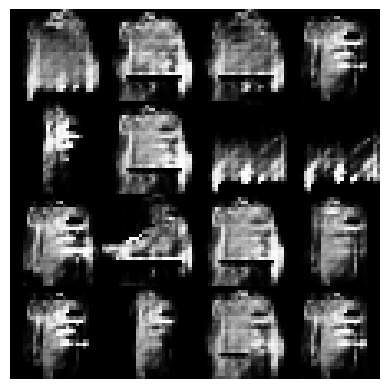

batch 0, g_loss : 0.025579, d_loss : -1.645449
batch 100, g_loss : 2.491810, d_loss : -1.662251
batch 200, g_loss : 1.817187, d_loss : -0.429321
batch 300, g_loss : 0.621740, d_loss : -0.566816

-------------------------------
Epoch is 11
1/1 [==============================] - 0s 22ms/step


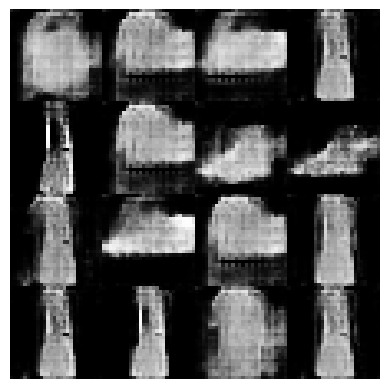

batch 0, g_loss : 0.756659, d_loss : -0.836539
batch 100, g_loss : 2.044750, d_loss : -0.654442
batch 200, g_loss : 0.335229, d_loss : -1.383528
batch 300, g_loss : 0.105961, d_loss : -1.797325

-------------------------------
Epoch is 12
1/1 [==============================] - 0s 18ms/step


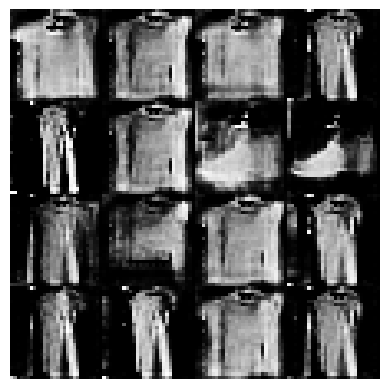

batch 0, g_loss : 0.020357, d_loss : -1.791563
batch 100, g_loss : 1.886686, d_loss : -2.130622
batch 200, g_loss : 2.168477, d_loss : 0.027253
batch 300, g_loss : 0.227757, d_loss : -1.829276

-------------------------------
Epoch is 13
1/1 [==============================] - 0s 21ms/step


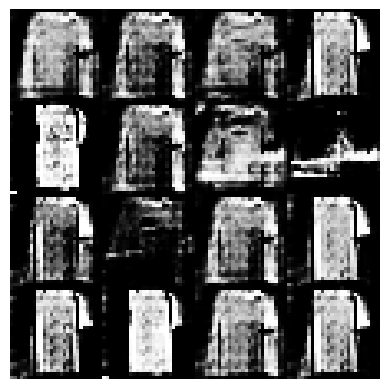

batch 0, g_loss : 0.144562, d_loss : -2.007857
batch 100, g_loss : 1.724433, d_loss : -2.221447
batch 200, g_loss : 0.705037, d_loss : -0.605948
batch 300, g_loss : 1.735343, d_loss : -0.067999

-------------------------------
Epoch is 14
1/1 [==============================] - 0s 18ms/step


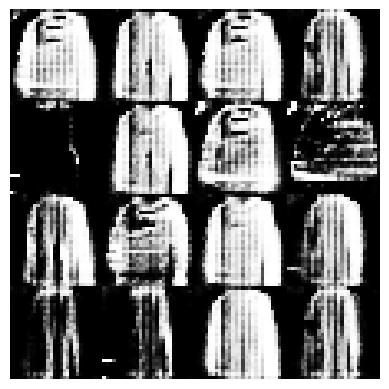

batch 0, g_loss : 1.021958, d_loss : -0.750079
batch 100, g_loss : 2.082631, d_loss : -0.563783
batch 200, g_loss : 1.167803, d_loss : -2.633376
batch 300, g_loss : 0.006883, d_loss : -1.482410

-------------------------------
Epoch is 15
1/1 [==============================] - 0s 19ms/step


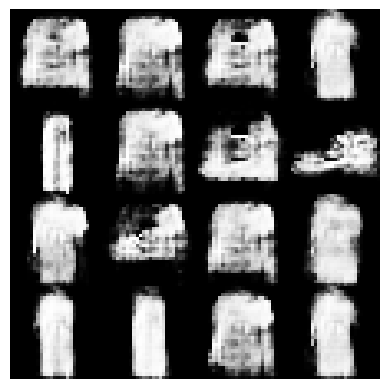

batch 0, g_loss : 0.475225, d_loss : -1.507890
batch 100, g_loss : 1.863184, d_loss : -1.807537
batch 200, g_loss : 1.236725, d_loss : -0.772646
batch 300, g_loss : 1.319550, d_loss : -2.125752

-------------------------------
Epoch is 16
1/1 [==============================] - 0s 36ms/step


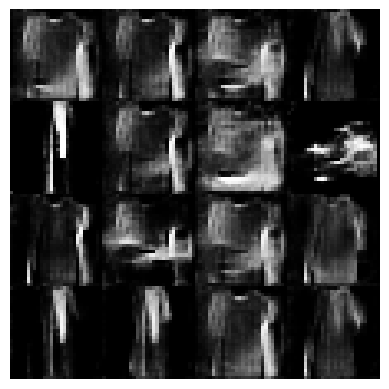

batch 0, g_loss : 2.226075, d_loss : -2.291875
batch 100, g_loss : 2.975330, d_loss : -1.498345
batch 200, g_loss : 0.060004, d_loss : 0.287866
batch 300, g_loss : 0.262861, d_loss : 0.080509

-------------------------------
Epoch is 17
1/1 [==============================] - 0s 27ms/step


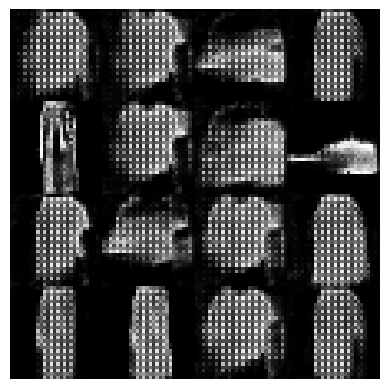

batch 0, g_loss : 1.845615, d_loss : 0.364196
batch 100, g_loss : 1.617459, d_loss : -1.342482
batch 200, g_loss : 2.098608, d_loss : -1.283045
batch 300, g_loss : 0.950909, d_loss : -1.369317

-------------------------------
Epoch is 18
1/1 [==============================] - 0s 19ms/step


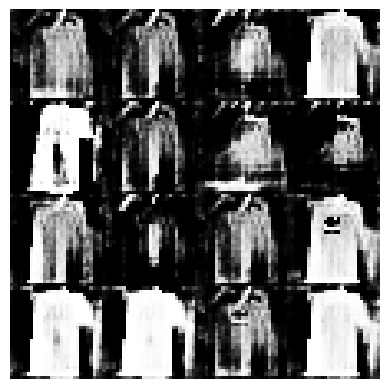

batch 0, g_loss : 0.469338, d_loss : -2.147191
batch 100, g_loss : 0.013131, d_loss : -2.256675
batch 200, g_loss : 2.158115, d_loss : -2.419243
batch 300, g_loss : 2.540109, d_loss : -2.596369

-------------------------------
Epoch is 19
1/1 [==============================] - 0s 18ms/step


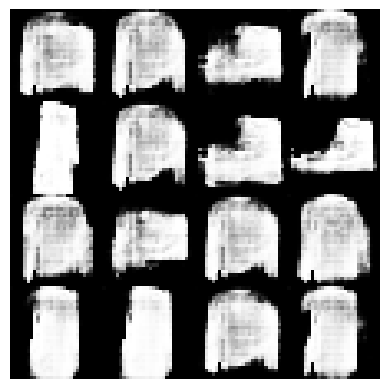

batch 0, g_loss : 2.376815, d_loss : -2.288310
batch 100, g_loss : 0.204321, d_loss : -1.823356
batch 200, g_loss : 0.741651, d_loss : 0.281657
batch 300, g_loss : 2.249206, d_loss : 0.112673

-------------------------------
Epoch is 20
1/1 [==============================] - 0s 23ms/step


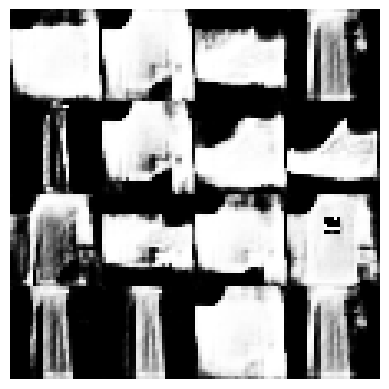

batch 0, g_loss : 2.395275, d_loss : 0.116873
batch 100, g_loss : 0.065822, d_loss : 0.016378
batch 200, g_loss : 0.661667, d_loss : 0.086015
batch 300, g_loss : 0.435542, d_loss : 0.183347

-------------------------------
Epoch is 21
1/1 [==============================] - 0s 18ms/step


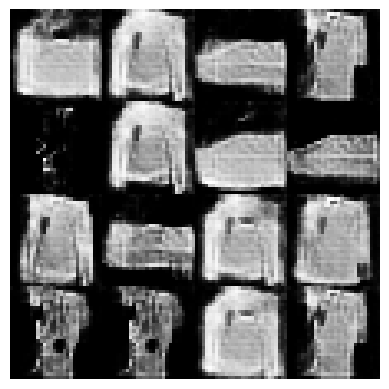

batch 0, g_loss : 0.144255, d_loss : 0.141266
batch 100, g_loss : 1.825006, d_loss : 0.190316
batch 200, g_loss : 1.986433, d_loss : -0.151352
batch 300, g_loss : 2.049380, d_loss : -3.003524

-------------------------------
Epoch is 22
1/1 [==============================] - 0s 18ms/step


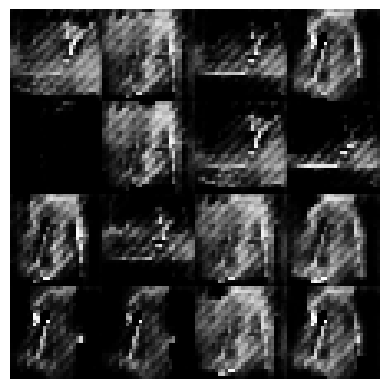

batch 0, g_loss : 2.552494, d_loss : -2.898164
batch 100, g_loss : 7.655318, d_loss : 1.326765
batch 200, g_loss : 0.001370, d_loss : -1.893891
batch 300, g_loss : 0.536848, d_loss : -0.916119

-------------------------------
Epoch is 23
1/1 [==============================] - 0s 26ms/step


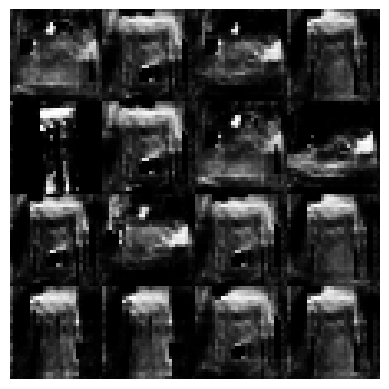

batch 0, g_loss : 1.049659, d_loss : -2.860870
batch 100, g_loss : 3.675625, d_loss : -2.383358
batch 200, g_loss : 0.060792, d_loss : -1.984400
batch 300, g_loss : 1.522572, d_loss : -2.341318

-------------------------------
Epoch is 24
1/1 [==============================] - 0s 27ms/step


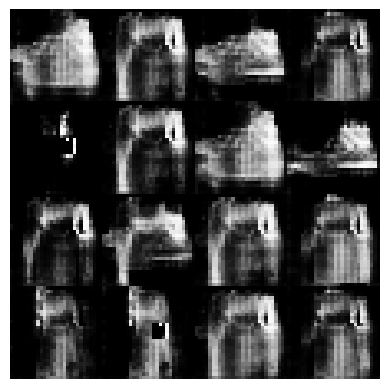

batch 0, g_loss : 3.667561, d_loss : -2.668468
batch 100, g_loss : 0.578242, d_loss : -0.484249
batch 200, g_loss : 0.331992, d_loss : -2.315634
batch 300, g_loss : 2.053168, d_loss : -2.934793

-------------------------------
Epoch is 25
1/1 [==============================] - 0s 19ms/step


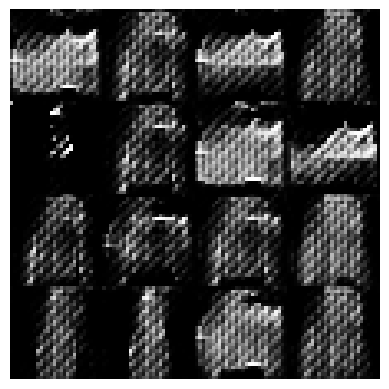

batch 0, g_loss : 1.583388, d_loss : -2.869504
batch 100, g_loss : 0.116906, d_loss : -1.665621
batch 200, g_loss : 2.582994, d_loss : -2.929996
batch 300, g_loss : 0.674336, d_loss : -2.282701

-------------------------------
Epoch is 26
1/1 [==============================] - 0s 24ms/step


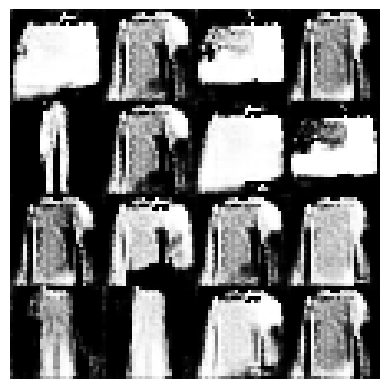

batch 0, g_loss : 0.757782, d_loss : -3.000264
batch 100, g_loss : 0.007160, d_loss : -2.753745
batch 200, g_loss : 1.085316, d_loss : -1.026905
batch 300, g_loss : 0.167273, d_loss : -2.384098

-------------------------------
Epoch is 27
1/1 [==============================] - 0s 19ms/step


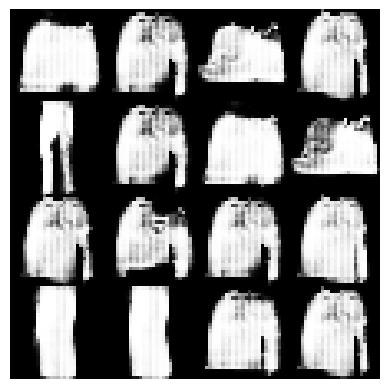

batch 0, g_loss : 0.821803, d_loss : -2.240938
batch 100, g_loss : 0.323889, d_loss : -3.371485
batch 200, g_loss : 1.446626, d_loss : -1.043406
batch 300, g_loss : 0.112274, d_loss : -2.682697

-------------------------------
Epoch is 28
1/1 [==============================] - 0s 20ms/step


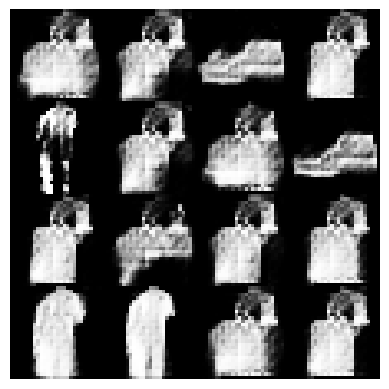

batch 0, g_loss : 2.436473, d_loss : -2.729490
batch 100, g_loss : 0.031534, d_loss : -3.432913
batch 200, g_loss : 2.236002, d_loss : -3.857458
batch 300, g_loss : 2.415671, d_loss : -3.670012

-------------------------------
Epoch is 29
1/1 [==============================] - 0s 20ms/step


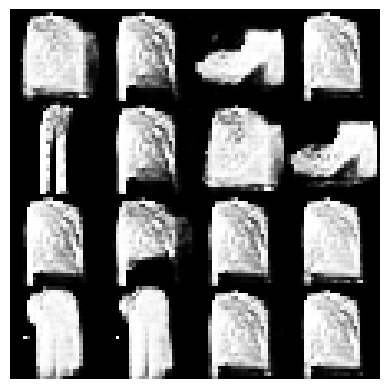

batch 0, g_loss : 2.663279, d_loss : -1.160995
batch 100, g_loss : 0.227142, d_loss : -4.032356
batch 200, g_loss : 1.718704, d_loss : 0.147185
batch 300, g_loss : 0.399018, d_loss : 0.112760

-------------------------------
Epoch is 30
1/1 [==============================] - 0s 18ms/step


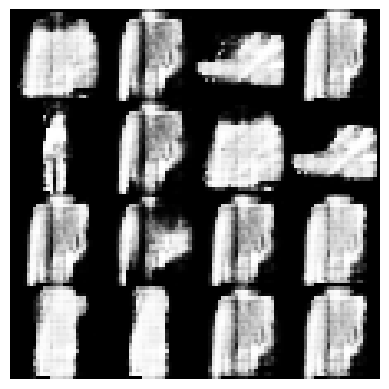

batch 0, g_loss : 0.284301, d_loss : 0.094114
batch 100, g_loss : 2.455424, d_loss : 0.026148
batch 200, g_loss : 0.767987, d_loss : -0.021458
batch 300, g_loss : 0.022712, d_loss : -0.059710

-------------------------------
Epoch is 31
1/1 [==============================] - 0s 18ms/step


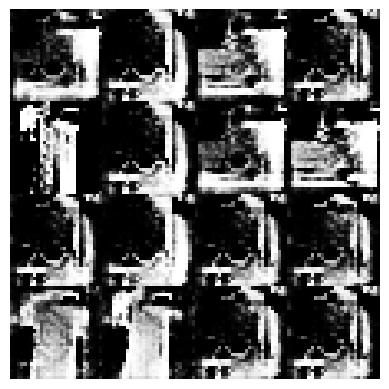

batch 0, g_loss : 0.011274, d_loss : -0.073345
batch 100, g_loss : 0.017874, d_loss : -0.089754
batch 200, g_loss : 2.472519, d_loss : -0.055413
batch 300, g_loss : 0.013366, d_loss : -0.190077

-------------------------------
Epoch is 32
1/1 [==============================] - 0s 18ms/step


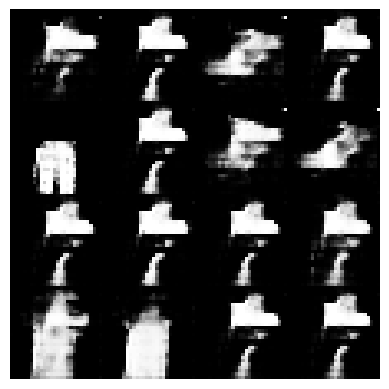

batch 0, g_loss : 0.010446, d_loss : -0.207251
batch 100, g_loss : 0.381123, d_loss : -0.172996
batch 200, g_loss : 2.973939, d_loss : -0.295605
batch 300, g_loss : 3.299458, d_loss : -2.289440

-------------------------------
Epoch is 33
1/1 [==============================] - 0s 18ms/step


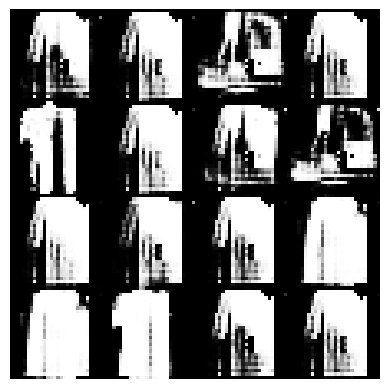

batch 0, g_loss : 2.736948, d_loss : -2.459063
batch 100, g_loss : 2.481498, d_loss : -1.404179
batch 200, g_loss : 0.213123, d_loss : -2.188131
batch 300, g_loss : 0.867053, d_loss : 0.252265

-------------------------------
Epoch is 34
1/1 [==============================] - 0s 18ms/step


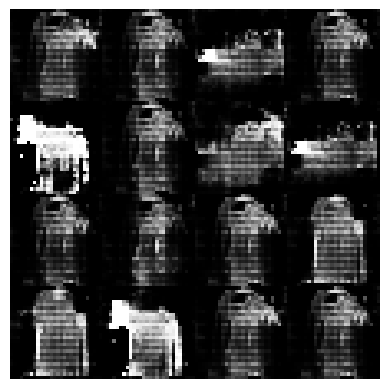

batch 0, g_loss : 0.968911, d_loss : 0.168662
batch 100, g_loss : 0.174113, d_loss : 0.123417
batch 200, g_loss : 0.700916, d_loss : -0.650221
batch 300, g_loss : 0.399806, d_loss : -0.175615

-------------------------------
Epoch is 35
1/1 [==============================] - 0s 20ms/step


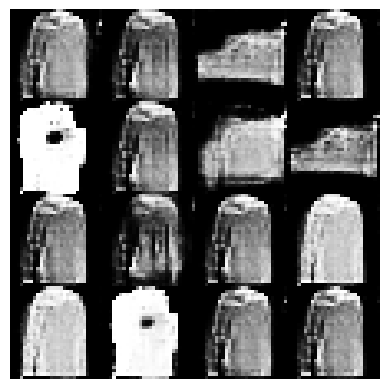

batch 0, g_loss : 0.431651, d_loss : -0.156349
batch 100, g_loss : 0.563601, d_loss : -0.564209
batch 200, g_loss : 2.921482, d_loss : -3.475193
batch 300, g_loss : 2.032821, d_loss : 0.081735

-------------------------------
Epoch is 36
1/1 [==============================] - 0s 18ms/step


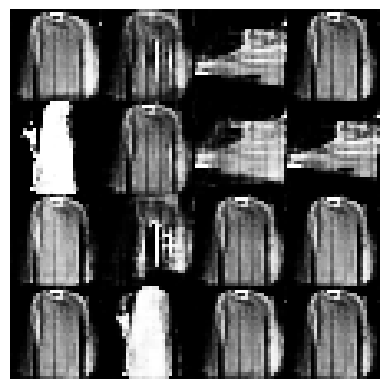

batch 0, g_loss : 0.310420, d_loss : -0.725137
batch 100, g_loss : 3.211205, d_loss : -4.850519
batch 200, g_loss : 6.198968, d_loss : -3.333839
batch 300, g_loss : 0.175845, d_loss : -0.097022

-------------------------------
Epoch is 37
1/1 [==============================] - 0s 24ms/step


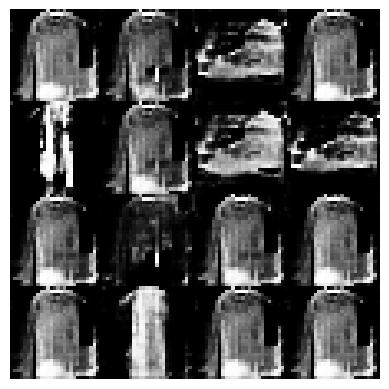

batch 0, g_loss : 0.104920, d_loss : -0.266098
batch 100, g_loss : 3.707579, d_loss : 0.827937
batch 200, g_loss : 1.015830, d_loss : 0.071676
batch 300, g_loss : 3.032940, d_loss : -1.322062

-------------------------------
Epoch is 38
1/1 [==============================] - 0s 18ms/step


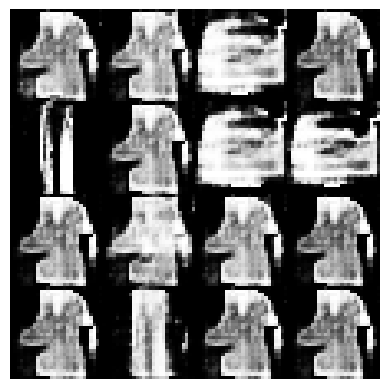

batch 0, g_loss : 0.181465, d_loss : -2.026090
batch 100, g_loss : 2.295873, d_loss : -3.183830
batch 200, g_loss : 0.376373, d_loss : -1.917400
batch 300, g_loss : 1.388860, d_loss : -2.562531

-------------------------------
Epoch is 39
1/1 [==============================] - 0s 20ms/step


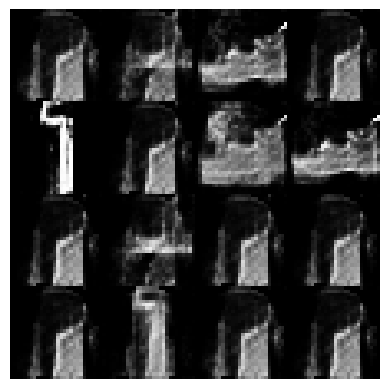

batch 0, g_loss : 1.347601, d_loss : -3.791114
batch 100, g_loss : 2.420265, d_loss : -5.585176
batch 200, g_loss : 1.200277, d_loss : -2.878827
batch 300, g_loss : 2.704606, d_loss : -1.521273

-------------------------------
Epoch is 40
1/1 [==============================] - 0s 25ms/step


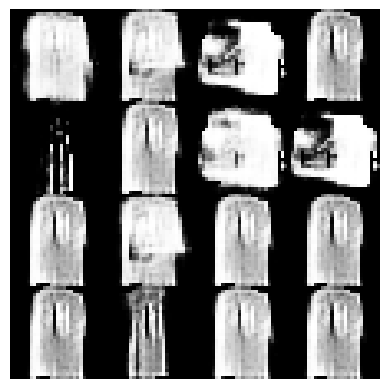

batch 0, g_loss : 5.180084, d_loss : -3.007540
batch 100, g_loss : 2.266744, d_loss : -4.429681
batch 200, g_loss : 2.451248, d_loss : -4.951270
batch 300, g_loss : 0.587413, d_loss : 0.318767

-------------------------------
Epoch is 41
1/1 [==============================] - 0s 18ms/step


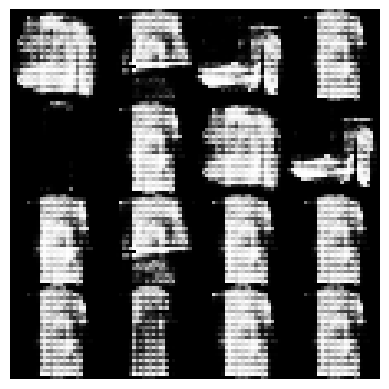

batch 0, g_loss : 0.722696, d_loss : 0.301348
batch 100, g_loss : 1.750900, d_loss : 0.217145
batch 200, g_loss : 0.215645, d_loss : 0.148319
batch 300, g_loss : 0.230211, d_loss : 0.224497

-------------------------------
Epoch is 42
1/1 [==============================] - 0s 19ms/step


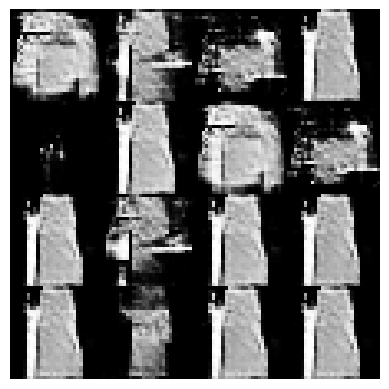

batch 0, g_loss : 0.244312, d_loss : 0.177802
batch 100, g_loss : 0.938579, d_loss : 0.198610
batch 200, g_loss : 2.099859, d_loss : 0.176771
batch 300, g_loss : 1.600954, d_loss : 0.261903

-------------------------------
Epoch is 43
1/1 [==============================] - 0s 19ms/step


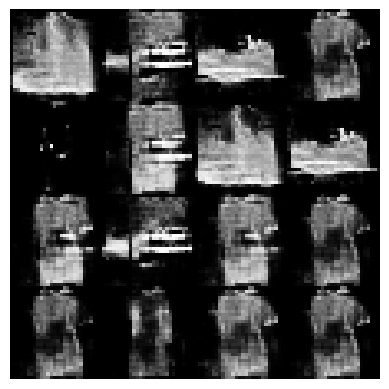

batch 0, g_loss : 1.424790, d_loss : 0.219309
batch 100, g_loss : 1.362941, d_loss : 0.031054
batch 200, g_loss : 1.503567, d_loss : 0.290745
batch 300, g_loss : 1.982044, d_loss : 0.151582

-------------------------------
Epoch is 44
1/1 [==============================] - 0s 21ms/step


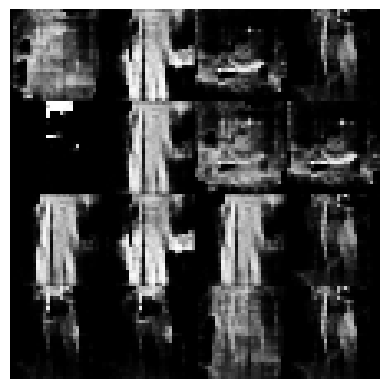

batch 0, g_loss : 1.636871, d_loss : 0.038479
batch 100, g_loss : 0.454292, d_loss : -0.689645
batch 200, g_loss : 0.202369, d_loss : -0.685161
batch 300, g_loss : 0.027544, d_loss : -1.682613

-------------------------------
Epoch is 45
1/1 [==============================] - 0s 26ms/step


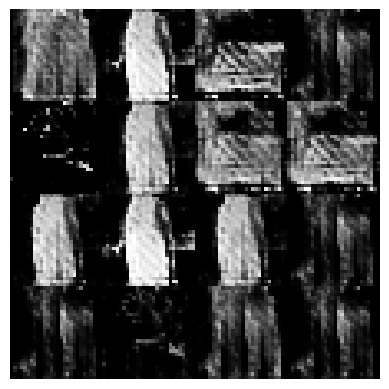

batch 0, g_loss : 3.559641, d_loss : -1.393344
batch 100, g_loss : 0.535017, d_loss : -2.912145
batch 200, g_loss : 0.053408, d_loss : -3.837948
batch 300, g_loss : 0.906674, d_loss : -2.884268

-------------------------------
Epoch is 46
1/1 [==============================] - 0s 18ms/step


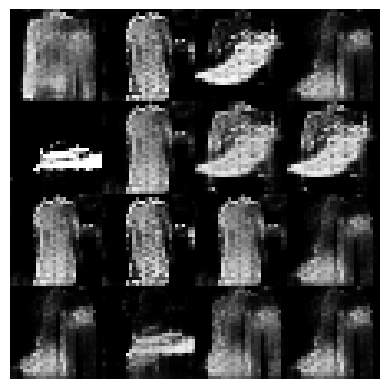

batch 0, g_loss : 0.100257, d_loss : -3.478116
batch 100, g_loss : 1.018896, d_loss : -1.437186
batch 200, g_loss : 2.984674, d_loss : -3.350181
batch 300, g_loss : 0.312939, d_loss : 0.116314

-------------------------------
Epoch is 47
1/1 [==============================] - 0s 18ms/step


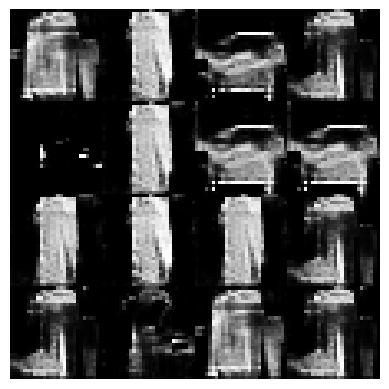

batch 0, g_loss : 0.484605, d_loss : 0.133149
batch 100, g_loss : 1.929758, d_loss : 0.137015
batch 200, g_loss : 1.464217, d_loss : -0.017962
batch 300, g_loss : 0.487790, d_loss : -0.006995

-------------------------------
Epoch is 48
1/1 [==============================] - 0s 18ms/step


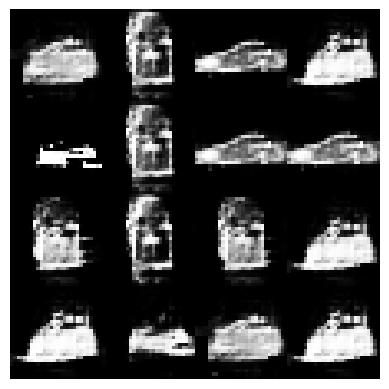

batch 0, g_loss : 0.587887, d_loss : -0.058553
batch 100, g_loss : 2.109351, d_loss : 0.051399
batch 200, g_loss : 0.518911, d_loss : -0.023280
batch 300, g_loss : 1.097861, d_loss : -0.032230

-------------------------------
Epoch is 49
1/1 [==============================] - 0s 18ms/step


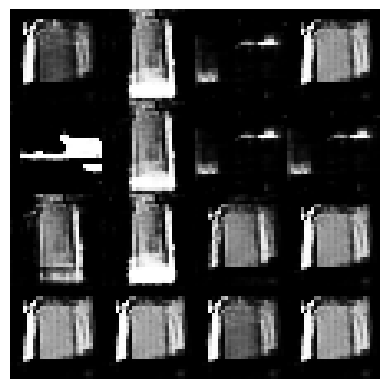

batch 0, g_loss : 0.850382, d_loss : -0.071561
batch 100, g_loss : 0.958433, d_loss : -0.317319
batch 200, g_loss : 0.634796, d_loss : -4.053332
batch 300, g_loss : 0.155595, d_loss : -4.281964
Training ended in 34.96093130509059 minutes


In [21]:
batch = 225
epochs = 50
g_model_post, d_model_post, _ = train_gan(X_train, y_train, batch, epochs, models)

##Evaluasi Model

1/1 [==============================] - 0s 20ms/step


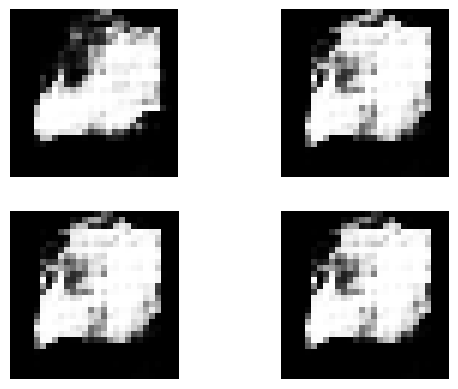

In [22]:
seed = tf.random.normal(shape=(4, 128))
images = g_model_post.predict(seed)

for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 20ms/step


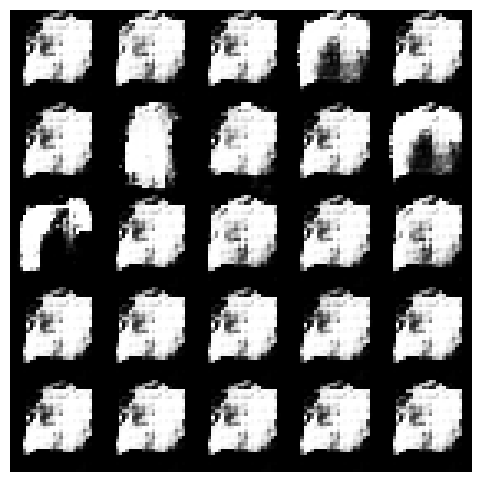

In [23]:
images = generate_images(g_model_post, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 41ms/step


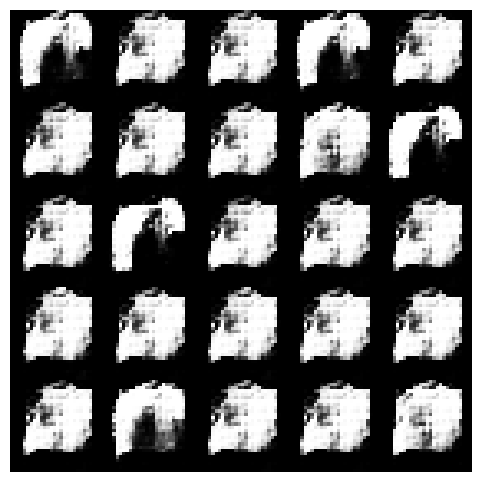

In [24]:
images = generate_images(g_model_post, 25)
plt.figure(figsize = (6,6))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()